# General linear model on fMRI data



## First level analysis

Analysis performed on a level of single subject (individual).

In [16]:
# Import libraries
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_stat_map, plot_img, show, plot_design_matrix, plot_contrast_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.reporting import get_clusters_table

## Load data

In [12]:
# Load a table with events 
events_path = r"F:\_Sorrow\PhD\FMRI\Datasets\sub-01\func\sub-01_task-rhymejudgment_events.tsv"
events = pd.read_csv(events_path, sep="\t")
print(events)

      onset  duration  trial_type
0    20.001       2.0        word
1    22.501       2.0        word
2    25.001       2.0        word
3    27.501       2.0        word
4    30.001       2.0        word
..      ...       ...         ...
59  307.510       2.0  pseudoword
60  310.010       2.0  pseudoword
61  312.510       2.0  pseudoword
62  315.010       2.0  pseudoword
63  317.510       2.0  pseudoword

[64 rows x 3 columns]


In [18]:
# Load preprocessed fMRI images
fmri_img = r"F:\_Sorrow\PhD\FMRI\Derivatives\sub-01\func\sub-01_task-rhymejudgment_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
fmri_img = nib.load(fmri_img)

In [19]:
# Load confounds and select six motion parameters
confounds_path = r"F:\_Sorrow\PhD\FMRI\Derivatives\sub-01\func\sub-01_task-rhymejudgment_desc-confounds_regressors.tsv"


## Run first level GLM

In [22]:
# Create design matrix

t_r = 2 # repetition time (TR)
import numpy as np

n_scans = fmri_img.shape[-1]  # 这里就是 160
tr = 2.0  # TR
frame_times = np.arange(n_scans) * tr

from nilearn.glm.first_level import make_first_level_design_matrix
design_matrix = make_first_level_design_matrix(frame_times, events,
                          drift_model='polynomial', drift_order=3)


plot_design_matrix

<function nilearn.plotting.matrix_plotting.plot_design_matrix(design_matrix, rescale=True, ax=None, output_file=None)>

In [23]:
# Define model
first_level_model = FirstLevelModel(t_r, 
                                    hrf_model='spm', 
                                    high_pass=.01,
                                    smoothing_fwhm=6)
# Fit model to data (fit(fmri_img, design_matrices=design_matrix))
first_level_model = first_level_model.fit(fmri_img, design_matrices=design_matrix)


Index(['pseudoword', 'word', 'drift_1', 'drift_2', 'drift_3', 'constant'], dtype='object')


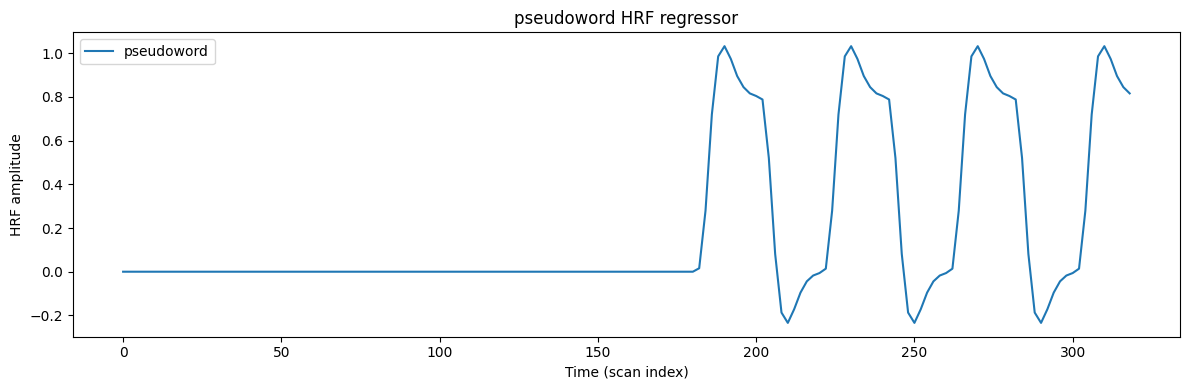

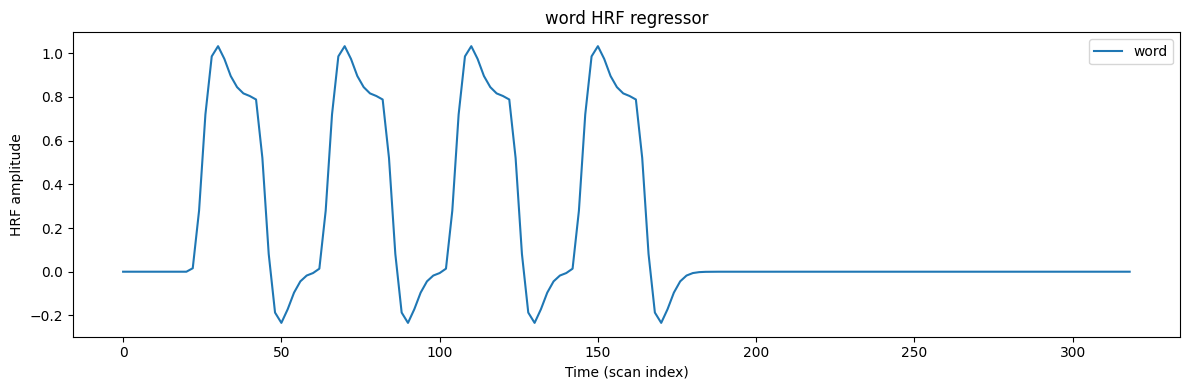

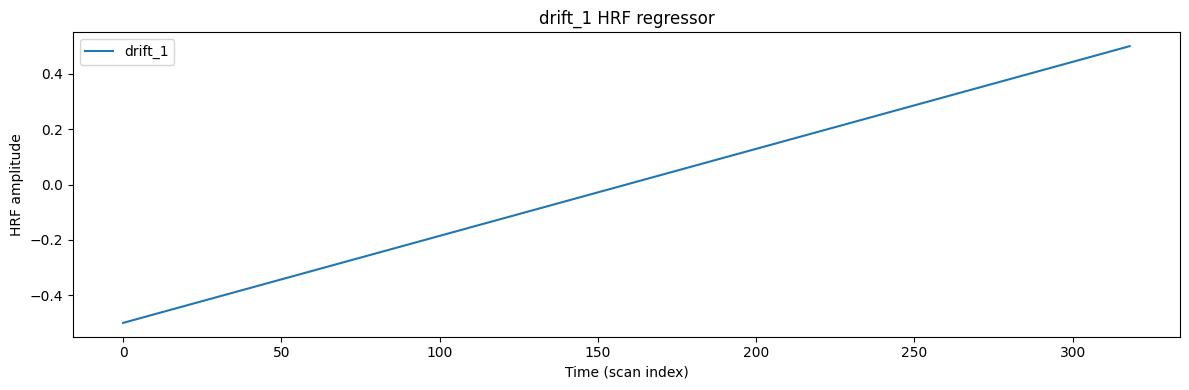

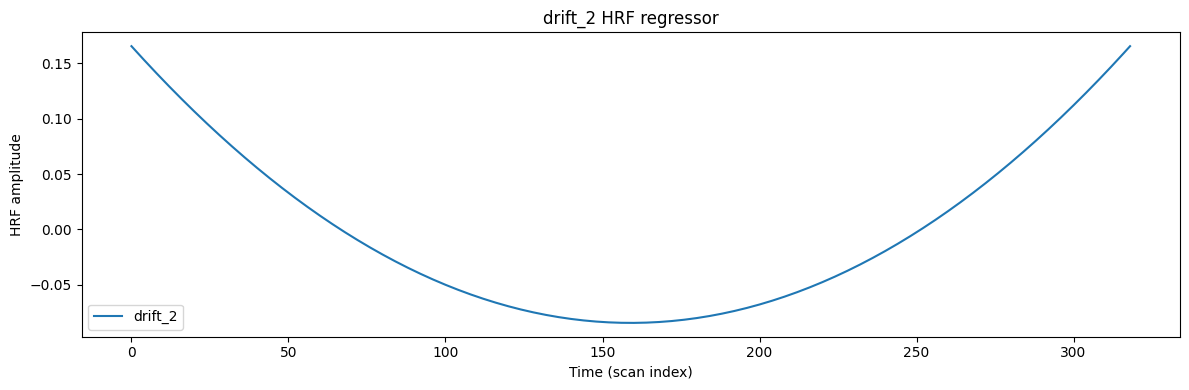

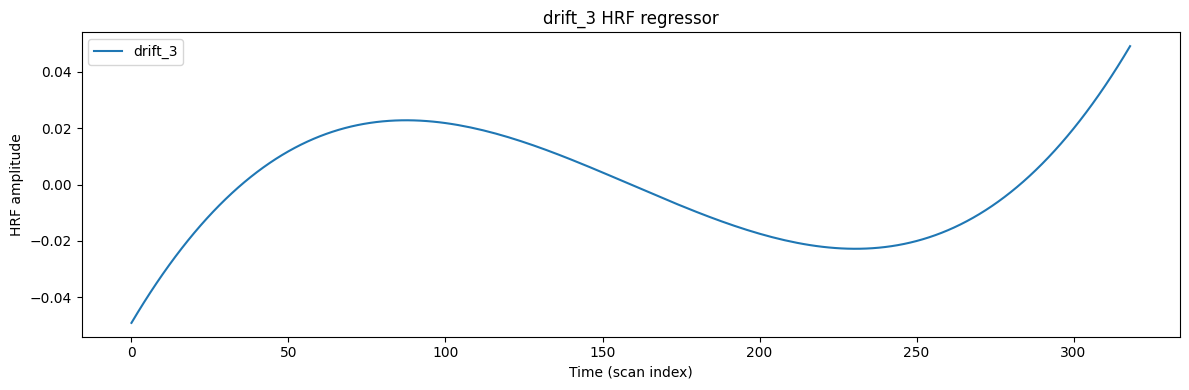

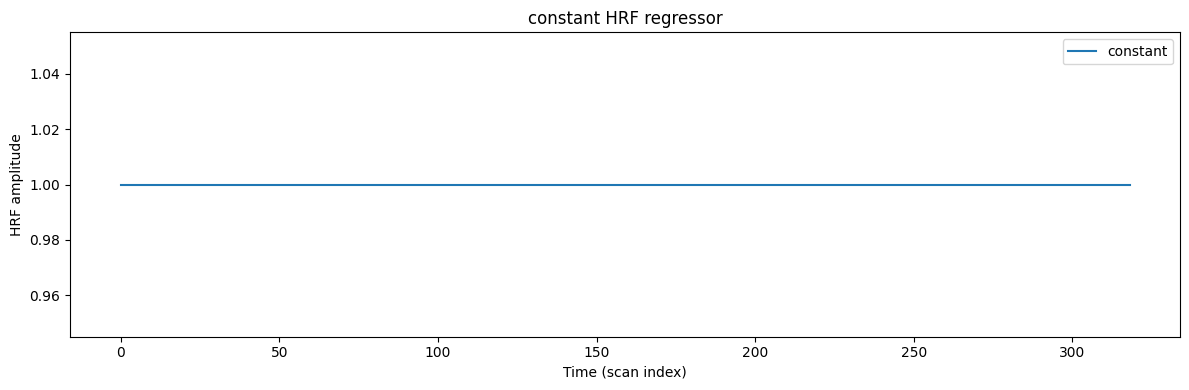

In [27]:
# Print timeseries of task-HRF data using plt.plot
import matplotlib.pyplot as plt

# 假设你已经有 design_matrix
# design_matrix.columns 里一般包含条件名（task）、drift、confounds等

# 先看有哪些列
print(design_matrix.columns)

# 假设你的任务条件叫 'task' 或 'conditionA'
# 你可以直接把这一列提取出来

for col in design_matrix.columns:
    condition_col = col  # 或改成你的实际列名

    plt.figure(figsize=(12, 4))
    plt.plot(design_matrix.index, design_matrix[condition_col], label=condition_col)
    plt.xlabel('Time (scan index)')
    plt.ylabel('HRF amplitude')
    plt.title(f'{condition_col} HRF regressor')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Create contrasts

In [32]:
# Create conditions
conditions = {'pseudoword': np.array([1, 0, 0, 0, 0, 0]), 
              'word': np.array([0, 1, 0, 0, 0, 0])}

<Axes: label='conditions'>

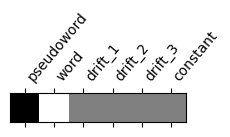

In [33]:
# Create contrasts (word > pseudoword, main word effect)
contrast_word_vs_pseudo = conditions['word'] - conditions['pseudoword']
# Plot contrast matrix with plot_contrast_matrix
from nilearn.plotting import plot_contrast_matrix
#contrast_word_vs_pseudo = np.array([-1, 1, 0, 0, 0, 0])
plot_contrast_matrix(contrast_word_vs_pseudo, design_matrix=design_matrix)


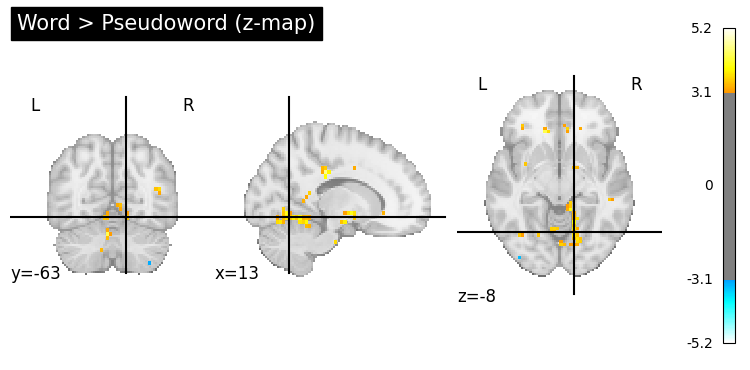

In [35]:
# Calculate statistic test for selected contrast (brain activity for word processing), use compute_contrasts
# 定义 word > pseudoword 的对比
# 计算 z-score map
z_map = first_level_model.compute_contrast(contrast_word_vs_pseudo,
                                  output_type='z_score')

# Plot results using plot_stat_map
from nilearn.plotting import plot_stat_map

plot_stat_map(z_map,
              threshold=3.1,    # 可以设置阈值
              display_mode='ortho', 
              title='Word > Pseudoword (z-map)')


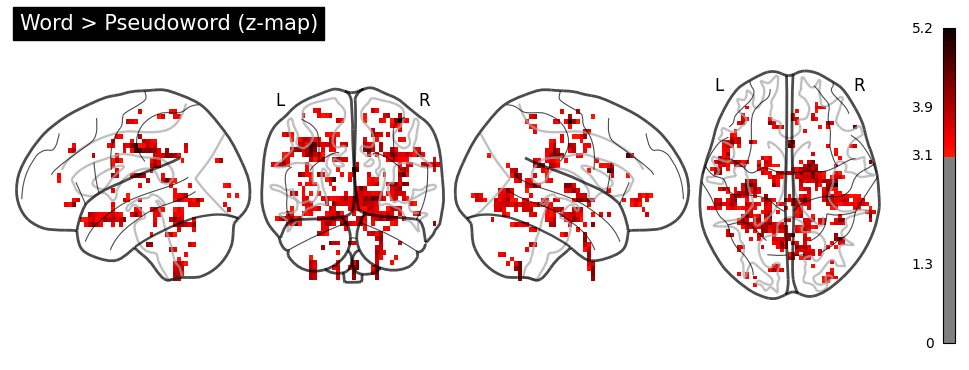

In [36]:
# Plot results on a glass brain
from nilearn.plotting import plot_glass_brain

plot_glass_brain(z_map,
                 threshold=3.1,
                 display_mode='lyrz', 
                 colorbar=True, 
                 title='Word > Pseudoword (z-map)')


In [37]:
# Plot results on interactive plot
from nilearn.plotting import view_img

view = view_img(z_map,
                threshold=3.1,
                title='Interactive Word > Pseudoword')
view.open_in_browser()  # 在浏览器中打开交互式视图



C:\Users\Sorrow\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Thresholding

In [42]:
from nilearn.glm import threshold_stats_img

# z_map 是 compute_contrast 输出的 z-score 图
# height_control: 'bonferroni' 或 'fdr'
# alpha: 显著性水平
thresholded_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control='bonferroni',
    two_sided=True
)

print('Corrected p<0.05 threshold (z-score): %.3f' % threshold)


Corrected p<0.05 threshold (z-score): 4.878


   Cluster ID       X       Y     Z  Peak Stat  Cluster Size (mm3)
0           1  38.375 -16.375  58.0   5.201207                  39


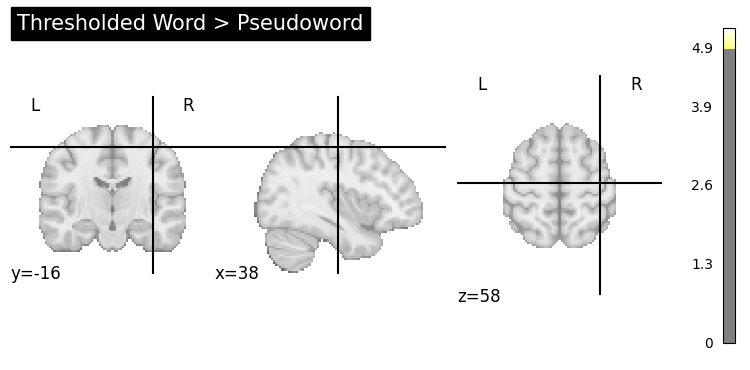

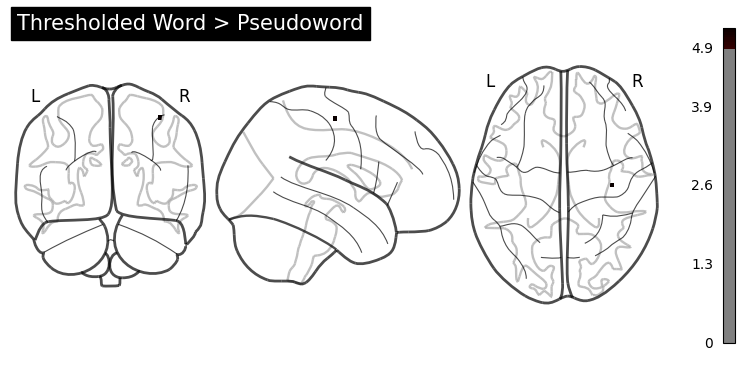

In [43]:
# Get cluster table using get_clusters_table

from nilearn.reporting import get_clusters_table

clusters = get_clusters_table(thresholded_map, stat_threshold=threshold, min_distance=10.0)
print(clusters)

from nilearn.plotting import plot_stat_map, plot_glass_brain

# 标准脑图
plot_stat_map(thresholded_map, display_mode='ortho', threshold=threshold,
              title='Thresholded Word > Pseudoword')

# 玻璃脑
plot_glass_brain(thresholded_map, threshold=threshold,
                 colorbar=True, title='Thresholded Word > Pseudoword')


# Repeat GLM analysis with design matrix extended by 6 motion parameters

In [53]:
# Repeat everything with motion as nuisance regressors.
import pandas as pd

# 读取 confounds_timeseries
confounds_file = r'F:\_Sorrow\PhD\FMRI\Derivatives\sub-01\func\sub-01_task-rhymejudgment_desc-confounds_timeseries.tsv'
confounds = pd.read_csv(confounds_file, sep='\t')
print(confounds.columns)

# 只选择 motion 列
motion_columns = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
motion = confounds[motion_columns]

# Print head of the dataframe
print(motion.head())

Index(['global_signal', 'global_signal_derivative1',
       'global_signal_derivative1_power2', 'global_signal_power2', 'csf',
       'csf_derivative1', 'csf_derivative1_power2', 'csf_power2',
       'white_matter', 'white_matter_derivative1',
       ...
       'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
       'rot_y_derivative1', 'rot_y_power2', 'rot_y_derivative1_power2',
       'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2',
       'rot_z_power2'],
      dtype='object', length=179)
    trans_x   trans_y   trans_z     rot_x     rot_y     rot_z
0  0.000144 -0.066055 -0.181045  0.002494 -0.000808 -0.000430
1  0.000022 -0.015570 -0.107557  0.001687 -0.000740 -0.000263
2 -0.000050  0.000406 -0.057056  0.001184 -0.000739  0.000041
3  0.000030  0.024692 -0.042864  0.000993 -0.000936  0.000058
4  0.000135  0.013512  0.024786  0.000610 -0.001045  0.000356


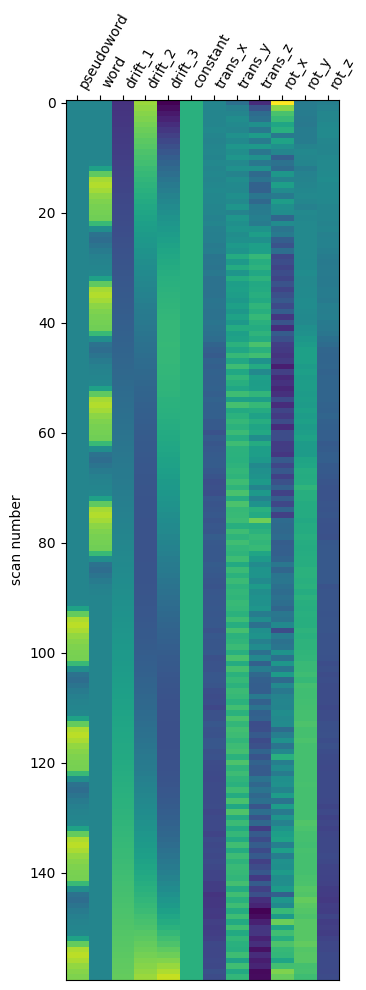

In [54]:
# Create conditions 
design_matrix_with_motion = make_first_level_design_matrix(
    frame_times,
    events=events,
    drift_model='polynomial',
    drift_order=3,
)

# 加入 motion regressors
for col in motion.columns:
    design_matrix_with_motion[col] = motion[col].values
    
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix

plot_design_matrix(design_matrix_with_motion)
plt.show()


<Axes: label='conditions'>

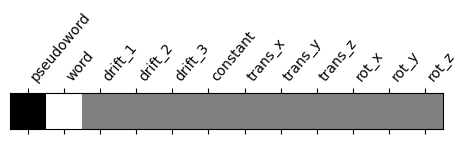

In [57]:
# Create contrasts
# Create conditions
conditions_mt = {'pseudoword': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 
              'word': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

# Plot contrast matrix

# Create contrasts (word > pseudoword, main word effect)
contrast_word_vs_pseudo_mt = conditions_mt['word'] - conditions_mt['pseudoword']
# Plot contrast matrix with plot_contrast_matrix

#contrast_word_vs_pseudo = np.array([-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
plot_contrast_matrix(contrast_word_vs_pseudo_mt, design_matrix=design_matrix_with_motion)

In [58]:
# Calculate statistic test for selected contrast (brain activity for word processing)

# 拟合模型
first_level_model.fit(fmri_img, design_matrices=design_matrix_with_motion)


FirstLevelModel(hrf_model='spm', smoothing_fwhm=6, t_r=2)

In [60]:
# Threshold z-maps to correct for multiple comparisons
# contrast_word_vs_pseudoword 已经定义好
z_map = first_level_model.compute_contrast(
    contrast_word_vs_pseudo_mt,
    output_type='z_score'
)


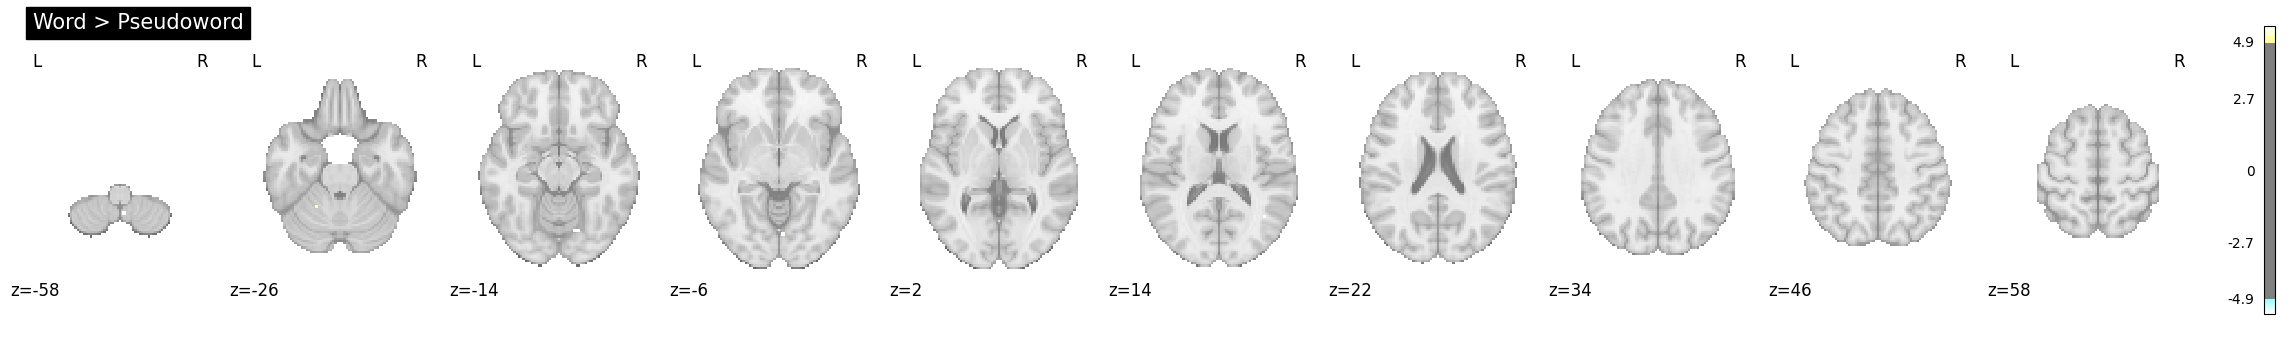

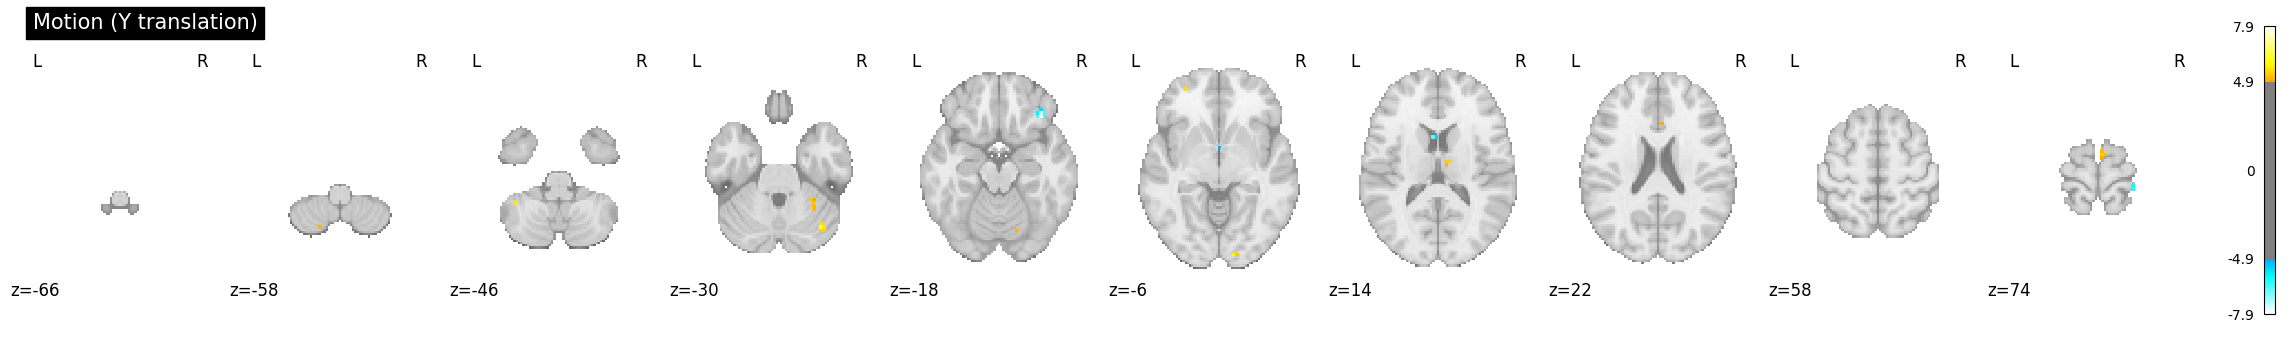

In [61]:
# Run contrast for motion effect (which voxels are associated with motion (translation in Y direction)?)
from nilearn.glm import threshold_stats_img

# 例如 Bonferroni 校正
thresholded_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control='bonferroni',
    two_sided=True
)

# 假设设计矩阵列顺序：
# ['pseudoword','word','drift_1','drift_2','drift_3','constant',
#  'trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']

motion_contrast = np.zeros(design_matrix_with_motion.shape[1])
motion_contrast[7] = 1  # 第 8 列是 trans_y

z_map_motion = first_level_model.compute_contrast(
    motion_contrast,
    output_type='z_score'
)

from nilearn.plotting import plot_stat_map

# Task contrast
plot_stat_map(z_map, threshold=threshold, display_mode='z', cut_coords=10, title='Word > Pseudoword')

# Motion contrast
plot_stat_map(z_map_motion, threshold=threshold, display_mode='z', cut_coords=10, title='Motion (Y translation)')
